In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style()

from itertools import cycle
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans

# Loading the Data: 2014 Boston Marathon Results

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [3]:
df.isnull().mean()*100

10k           0.000000
name          0.000000
division      0.000000
25k           0.000000
gender        0.000000
age           0.000000
official      0.000000
bib           0.000000
genderdiv     0.000000
ctz          96.110555
35k           0.000000
overall       0.000000
pace          0.000000
state         8.054027
30k           0.000000
5k            0.000000
half          0.000000
20k           0.000000
country       0.000000
city          0.003127
40k           0.000000
dtype: float64

# Data Exploration

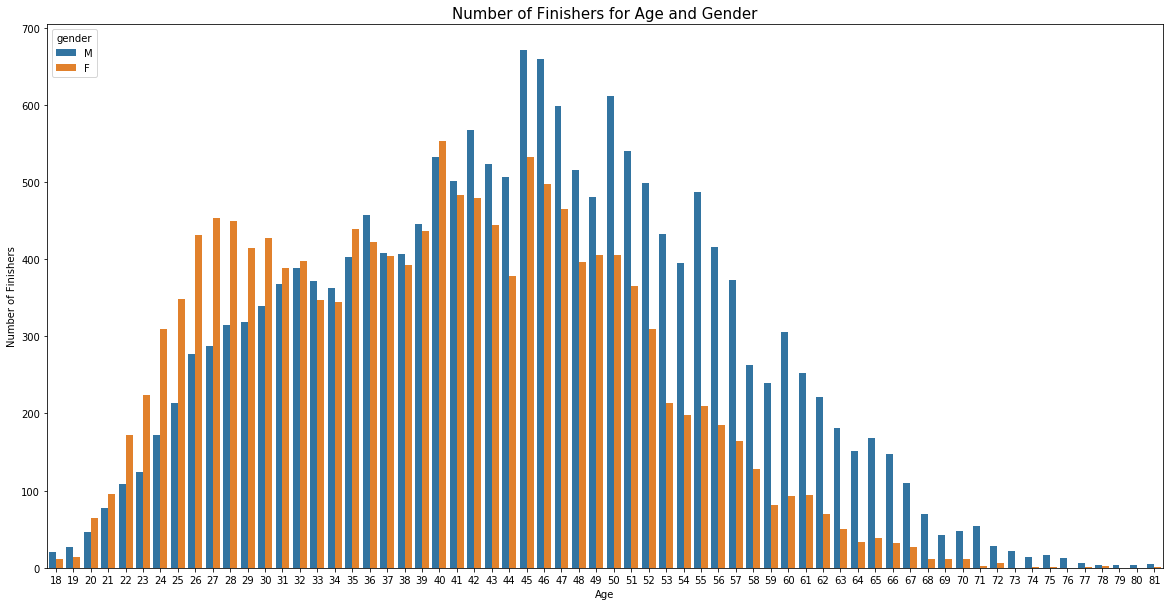

In [4]:
plt.figure(figsize=(20,10))
sns.countplot(x='age', hue='gender', data=df)
plt.title('Number of Finishers for Age and Gender', fontsize=15)
plt.xlabel('Age')
plt.ylabel('Number of Finishers')
plt.show()

## Age Distributions

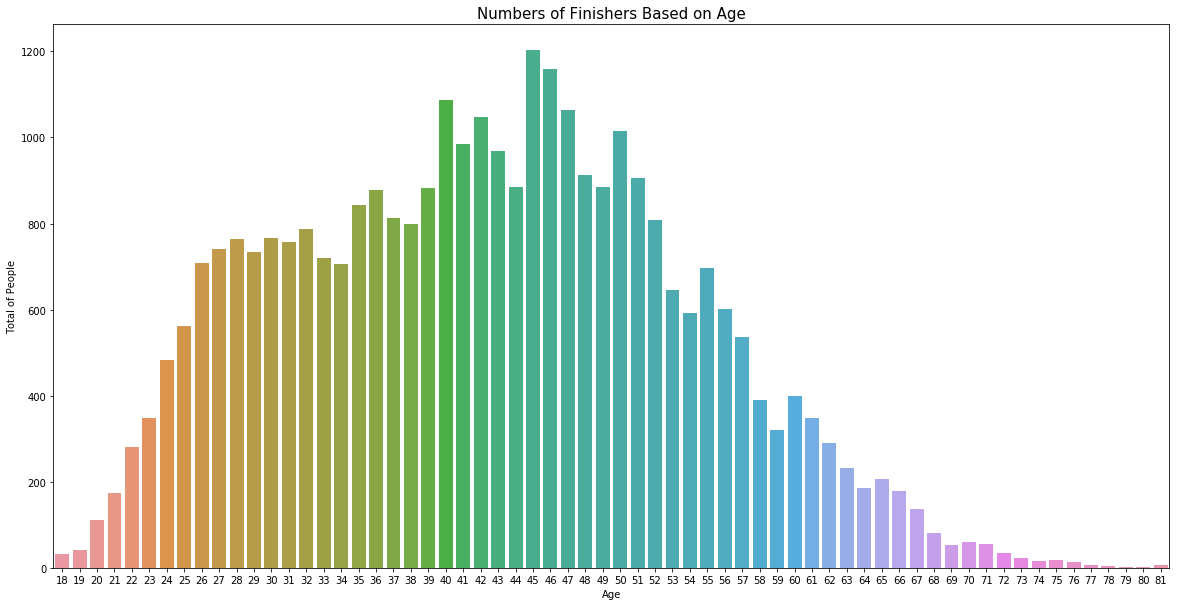

In [5]:
plt.figure(figsize=(20,10))
sns.countplot('age', data=df)
plt.title('Numbers of Finishers Based on Age', fontsize=15)
plt.xlabel('Age')
plt.ylabel('Total of People')
plt.show()

In [6]:
df = df.drop(['name', 'ctz', 'state', 'city', 'bib', 'country', 'division', 'genderdiv'],1)

In [7]:
df.isnull().sum()

10k         0
25k         0
gender      0
age         0
official    0
35k         0
overall     0
pace        0
30k         0
5k          0
half        0
20k         0
40k         0
dtype: int64

In [8]:
# binarize 'Gender'
df['gender'] = df.gender.map(lambda x: 0 if x is 'F' else 1)

In [9]:
df = df.apply(pd.to_numeric, errors='coerce')
df.dtypes

10k         float64
25k         float64
gender        int64
age           int64
official    float64
35k         float64
overall       int64
pace        float64
30k         float64
5k          float64
half        float64
20k         float64
40k         float64
dtype: object

In [10]:
df = df.dropna()
df.describe()

,10k,25k,gender,age,official,35k,overall,pace,30k,5k,half,20k,40k
count,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000
mean,51.629039,133.581175,0.552435,42.385067,241.952383,196.033373,15833.958924,9.236463,163.894883,25.678261,111.211481,105.321404,228.189990
std,8.710102,25.571480,0.497251,11.299795,50.842552,40.775036,9182.223743,1.939150,32.889354,4.215381,20.306387,19.159500,48.074493
min,16.620000,45.800000,0.000000,18.000000,80.600000,67.420000,1.000000,3.080000,56.450000,7.750000,38.030000,36.100000,76.100000
25%,45.370000,115.430000,0.000000,33.000000,205.300000,166.950000,7880.000000,7.830000,140.520000,22.620000,96.750000,91.670000,193.620000
50%,50.280000,128.850000,1.000000,42.000000,231.980000,187.850000,15829.000000,8.850000,157.500000,25.050000,107.680000,102.000000,218.470000
75%,57.000000,147.700000,1.000000,50.000000,272.200000,219.370000,23785.000000,10.380000,182.200000,28.400000,122.680000,116.150000,256.570000
max,112.380000,289.020000,1.000000,81.000000,538.880000,449.330000,31931.000000,20.570000,376.380000,86.950000,236.670000,224.350000,508.350000



**Draw scatterplots for joint relationships:

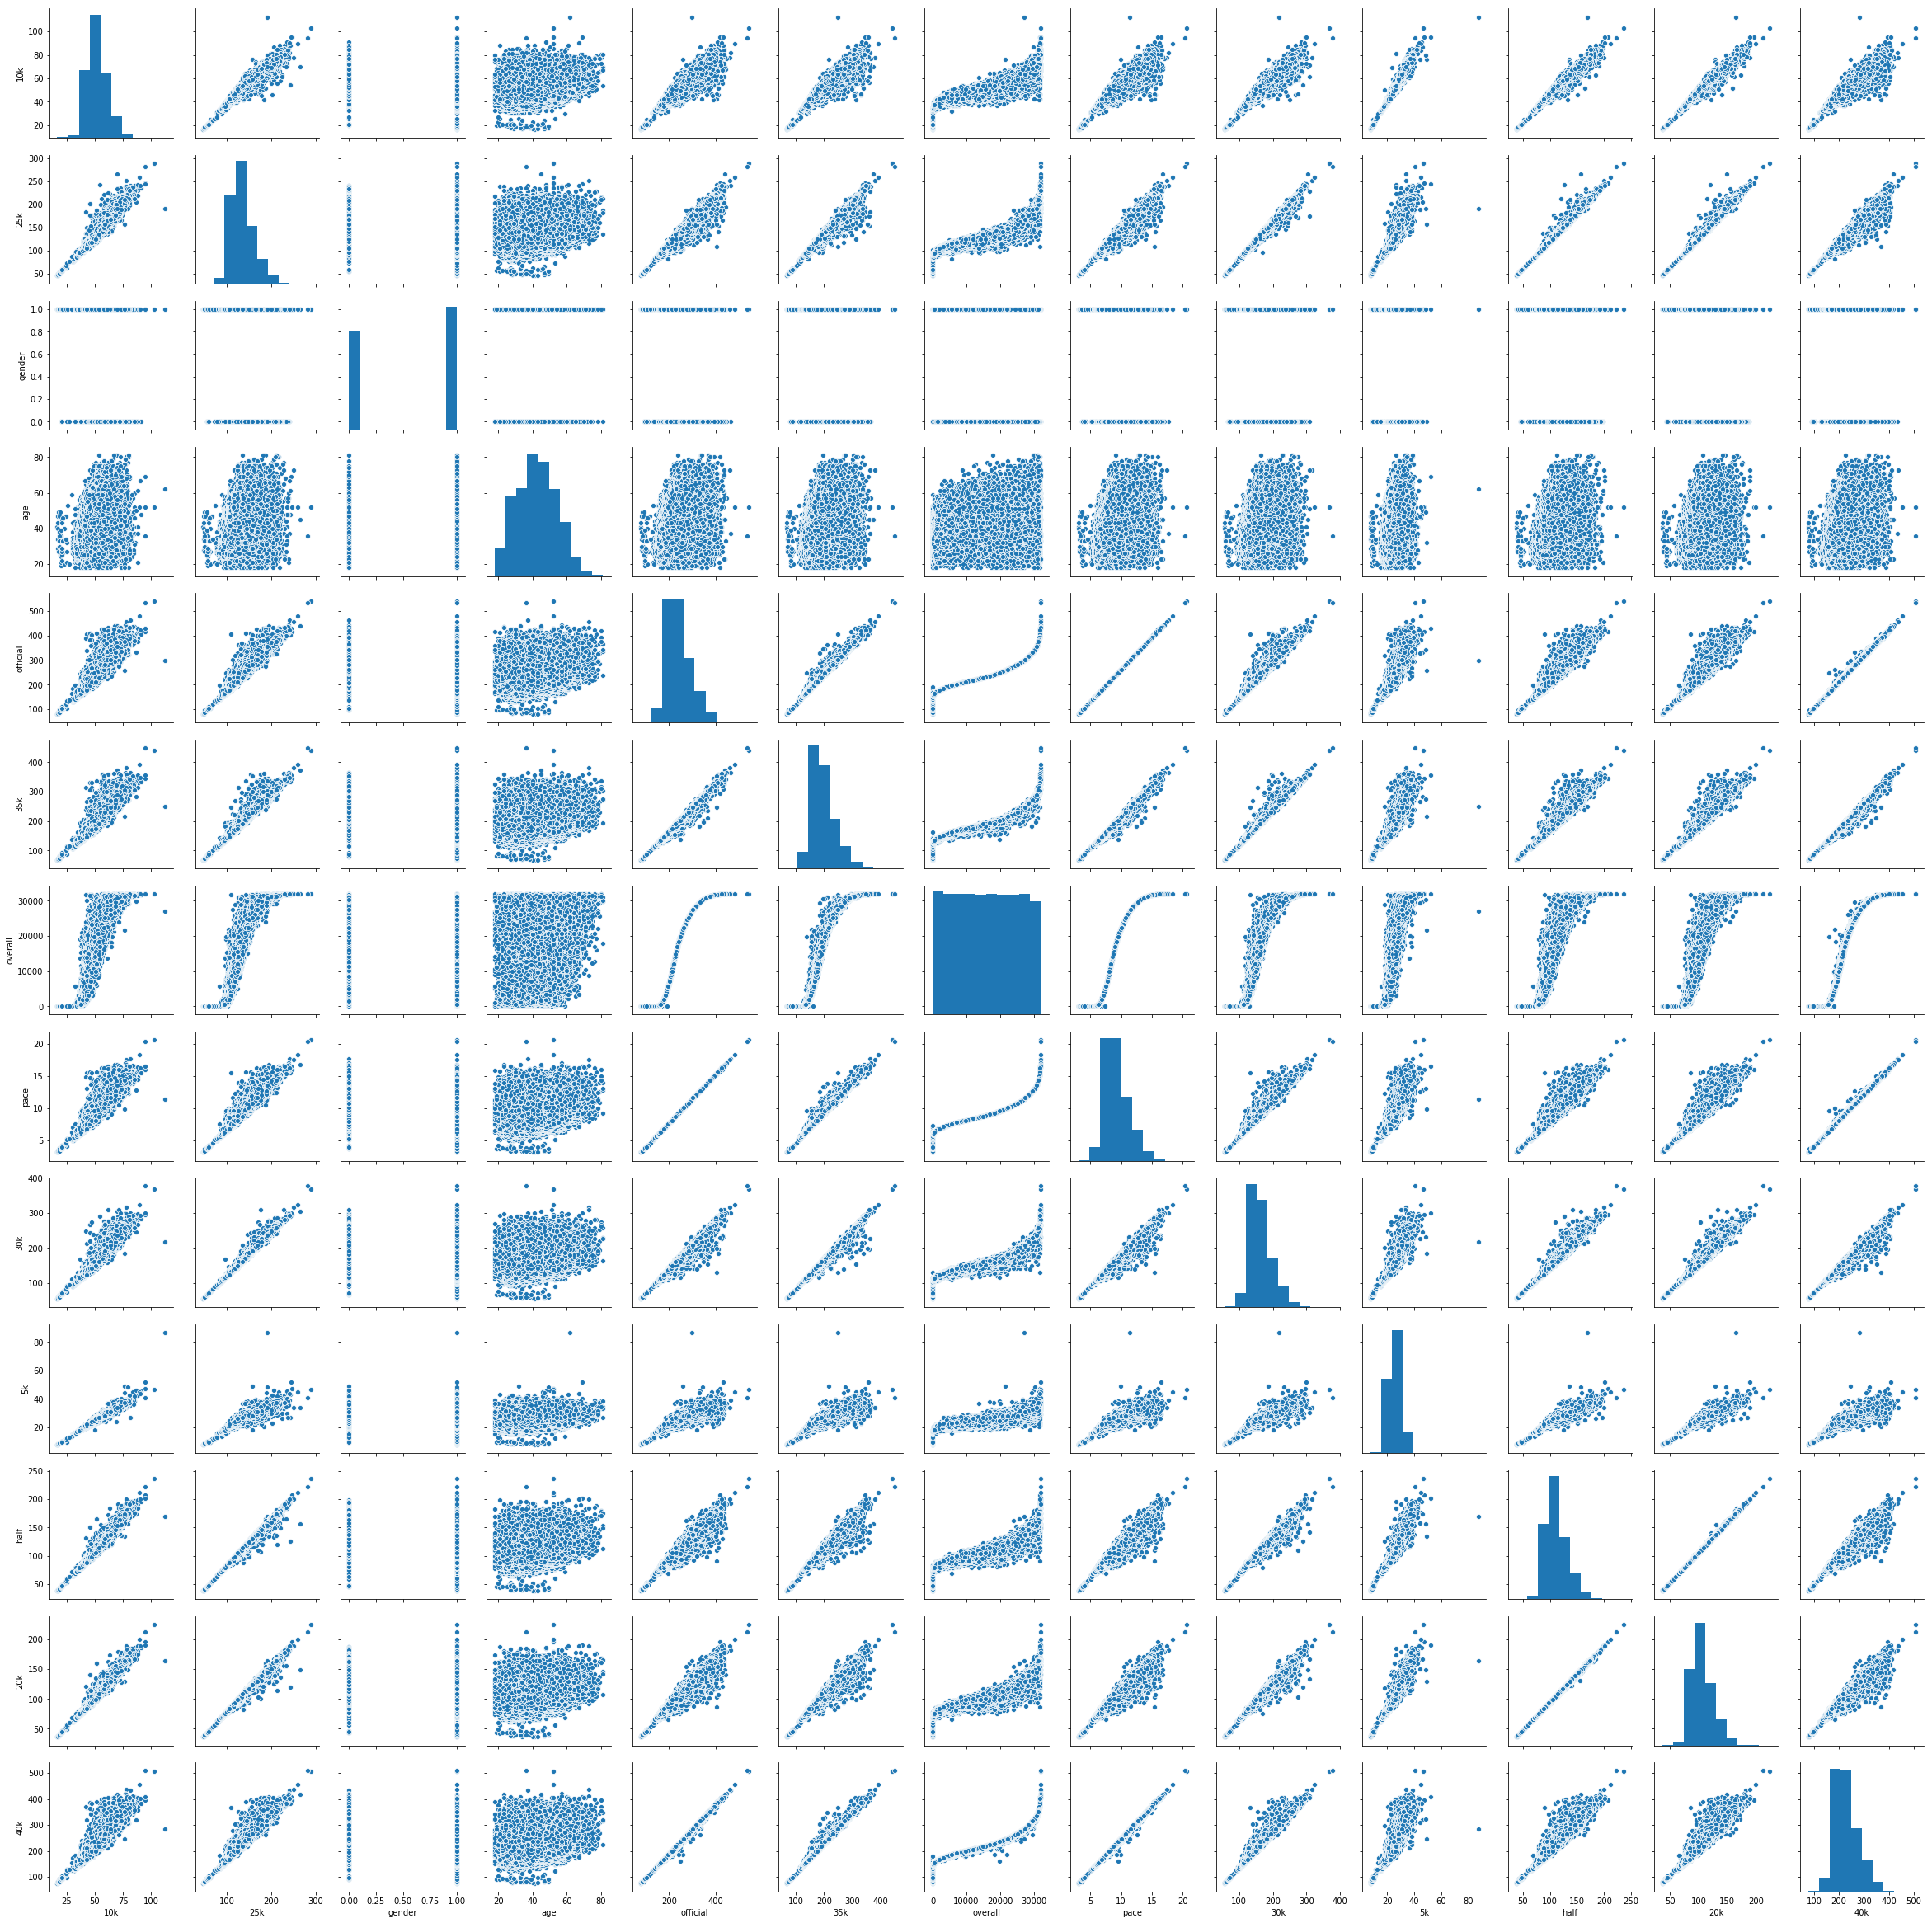

In [11]:
sns.pairplot(df)

As we can see from the plot above, using the total datas of the dataset, it is difficult to find a relation between age and performance.

## Machine Learning

In [14]:
# make sure the number of rows divides evenly into 4 samples
rows = df.shape[0] - df.shape[0]%4
df = df.iloc[:rows, :]

In [15]:
df.shape

(31648, 13)

In [16]:
# normalize features
X_norm = normalize(df)

# dataframe to store features and predicted cluster memberships
ypred = pd.DataFrame()

# create the 2-feature PCA for graphing purposes
X_pca = PCA(2).fit_transform(X_norm)

# split data into 4 equally sized samples
Xhalf1, Xhalf2, Xpca_h1, Xpca_h2 = train_test_split(X_norm, X_pca, test_size=0.5, random_state=1)

X1, X2, Xpca1, Xpca2 = train_test_split(Xhalf1, Xpca_h1, test_size=0.5, random_state=1)
X3, X4, Xpca3, Xpca4 = train_test_split(Xhalf2, Xpca_h2, test_size=0.5, random_state=1)

### KMeans

In [17]:
# pass a list of tuples and a counter that increments each time we go through a loop.
# The tuples are the data to be used for kmeans and the PCA features for graphing
# We use kmeans to fit a model to the data, then store the predicted values and the 2 featured PCA solutions in the dataframe
for counter, data in enumerate([(X1, Xpca1),
                                (X2, Xpca2),
                                (X3, Xpca3),
                                (X4, Xpca4)]):
    # put the features into ypred
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:,0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:,1]
    
    # generate cluster predictions and store them for clusters 2 to 6
    for nclust in range(2,7):
        pred = KMeans(n_clusters=nclust, random_state=1).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

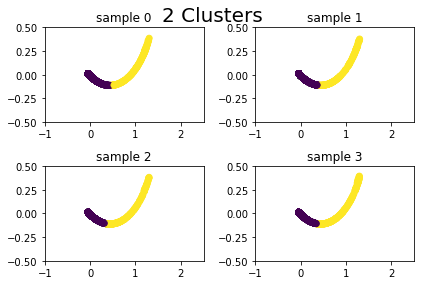

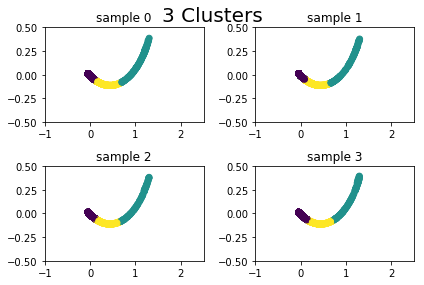

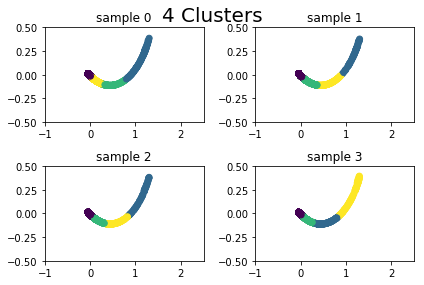

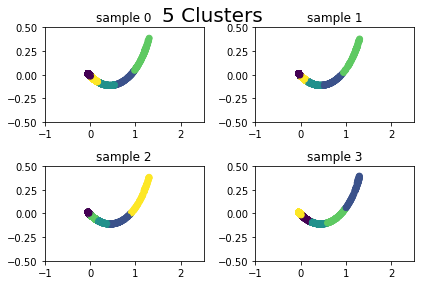

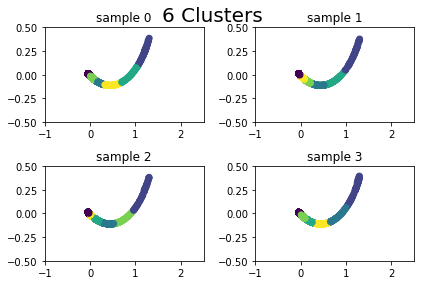

In [54]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 7):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-1, 2.5])
        axarr[rows, cols].set_ylim([-0.5, 0.5])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

In [19]:
for i in range(2,7):
    for sample in [X1, X2, X3, X4]:
        model = KMeans(n_clusters=i, random_state=1).fit(sample)
        labels = model.labels_
        s_scores = metrics.silhouette_score(sample, labels, metric='euclidean')
        print('Clusters = {}'.format(i))
        print(s_scores)

Clusters = 2
0.9393194575971062
Clusters = 2
0.9336302681688092
Clusters = 2
0.9278156653352012
Clusters = 2
0.9241593501453078
Clusters = 3
0.8809084916945826
Clusters = 3
0.8683177880786225
Clusters = 3
0.8809652346368732
Clusters = 3
0.8885457454563778
Clusters = 4
0.8213235217907681
Clusters = 4
0.8468568570967168
Clusters = 4
0.8378930519098425
Clusters = 4
0.8262401921435111
Clusters = 5
0.7959457800780261
Clusters = 5
0.7782974949667444
Clusters = 5
0.7813338029095943
Clusters = 5
0.8051891602561511
Clusters = 6
0.7628906304774427
Clusters = 6
0.748200102287557
Clusters = 6
0.7497469685566872
Clusters = 6
0.7682487649285301


### Overall:

* All four samples performed in a similar fashion given the differences in the amount of clusters
* Silhouette scores of each clusters are very similar, indicating consistent results.


## Mean Shift Model

In [27]:
# initialize dataframe
ypred_ms = pd.DataFrame()
score_ms = pd.DataFrame(columns=['clusters_pred', 'mean_shift', 'quantile'])

# keep track of counts of the model and use data from the different folds
for counter, data in enumerate([X1,X2,X3,X4]):
    # quantile list
    for n in [0.6, 0.7, 0.8, 0.9]:
        # estimate the number of clusters
        bandwidth = estimate_bandwidth(data, quantile=n, n_samples=1000)
        # ensuring all sets are same length
        data = data[:7912][:]
        # instantiate and fit predict model before adding to df
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        pred = ms.fit_predict(data)
        labels = ms.labels_
        centers = len(np.unique(labels))
        ypred_ms['clust' + str(centers) + '_sample' + str(counter)] = pred
        # calc silhoutte scores 
        s_scores = metrics.silhouette_score(data, labels, metric='euclidean')
        score_ms = score_ms.append({'clusters_pred' : 'clust'+ str(centers) + '_sample' + str(counter),
                                    'silhouette_score' : s_scores,
                                    'quantile' : n,
                                    'mean_shift' : 'MS'}, ignore_index=True)
        
score_ms.sort_values(by='silhouette_score', ascending=False)

,clusters_pred,mean_shift,quantile,silhouette_score
3,clust4_sample0,MS,0.9,0.909106
15,clust4_sample3,MS,0.9,0.898176
11,clust6_sample2,MS,0.9,0.896375
7,clust5_sample1,MS,0.9,0.894795
2,clust8_sample0,MS,0.8,0.884995
10,clust10_sample2,MS,0.8,0.871806
14,clust7_sample3,MS,0.8,0.864625
6,clust9_sample1,MS,0.8,0.862616
5,clust12_sample1,MS,0.7,0.862488
4,clust14_sample1,MS,0.6,0.860906


In [20]:
# initialize dataframe
ypred_ms = pd.DataFrame()
score_ms = pd.DataFrame(columns=['clusters_pred', 'mean_shift', 'quantile'])

# keep track of counts of the model and use data from the different folds
for counter, data in enumerate([X1,X2,X3,X4]):
    # quantile list
    for n in [0.3, 0.4, 0.5, 0.6]:
        # estimate the number of clusters
        bandwidth = estimate_bandwidth(data, quantile=n, n_samples=1000)
        # ensuring all sets are same length
        data = data[:7912][:]
        # instantiate and fit predict model before adding to df
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        pred = ms.fit_predict(data)
        labels = ms.labels_
        centers = len(np.unique(labels))
        ypred_ms['clust' + str(centers) + '_sample' + str(counter)] = pred
        # calc silhoutte scores 
        s_scores = metrics.silhouette_score(data, labels, metric='euclidean')
        score_ms = score_ms.append({'clusters_pred' : 'clust'+ str(centers) + '_sample' + str(counter),
                                    'silhouette_score' : s_scores,
                                    'quantile' : n,
                                    'mean_shift' : 'MS'}, ignore_index=True)
        
score_ms.sort_values(by='silhouette_score', ascending=False)

,clusters_pred,mean_shift,quantile,silhouette_score
2,clust14_sample0,MS,0.5,0.861364
7,clust14_sample1,MS,0.6,0.860906
3,clust12_sample0,MS,0.6,0.859789
15,clust13_sample3,MS,0.6,0.857584
1,clust18_sample0,MS,0.4,0.854361
11,clust15_sample2,MS,0.6,0.853536
6,clust13_sample1,MS,0.5,0.849281
5,clust14_sample1,MS,0.4,0.848565
10,clust18_sample2,MS,0.5,0.846515
0,clust15_sample0,MS,0.3,0.840000


In [21]:
# initialize dataframe
ypred_ms = pd.DataFrame()
score_ms = pd.DataFrame(columns=['clusters_pred', 'mean_shift', 'quantile'])

# keep track of counts of the model and use data from the different folds
for counter, data in enumerate([X1,X2,X3,X4]):
    # quantile list
    for n in [0.1, 0.2, 0.3, 0.4]:
        # estimate the number of clusters
        bandwidth = estimate_bandwidth(data, quantile=n, n_samples=1000)
        # ensuring all sets are same length
        data = data[:7912][:]
        # instantiate and fit predict model before adding to df
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        pred = ms.fit_predict(data)
        labels = ms.labels_
        centers = len(np.unique(labels))
        ypred_ms['clust' + str(centers) + '_sample' + str(counter)] = pred
        # calc silhoutte scores 
        s_scores = metrics.silhouette_score(data, labels, metric='euclidean')
        score_ms = score_ms.append({'clusters_pred' : 'clust'+ str(centers) + '_sample' + str(counter),
                                    'silhouette_score' : s_scores,
                                    'quantile' : n,
                                    'mean_shift' : 'MS'}, ignore_index=True)

In [22]:
score_ms.sort_values(by='silhouette_score', ascending=False)

,clusters_pred,mean_shift,quantile,silhouette_score
1,clust18_sample0,MS,0.2,0.859470
3,clust18_sample0,MS,0.4,0.854361
7,clust14_sample1,MS,0.4,0.848565
2,clust15_sample0,MS,0.3,0.840000
0,clust20_sample0,MS,0.1,0.829315
12,clust12_sample3,MS,0.1,0.825370
14,clust17_sample3,MS,0.3,0.821177
15,clust17_sample3,MS,0.4,0.820815
6,clust14_sample1,MS,0.3,0.816529
5,clust14_sample1,MS,0.2,0.815363


### Overall:

* Mean Shift scores lower than Kmeans
* Larger bandwidth give better silhouette scores

## Spectral Clustering

In [23]:
ypred_sc = pd.DataFrame()
score_sc = pd.DataFrame(columns=['clusters_pred', 'silhouette_score'])

for counter, data in enumerate([(X1, Xpca1),
                                (X2, Xpca2),
                                (X3, Xpca3),
                                (X4, Xpca4)]):
    # put features into ypred
    ypred_sc['pca_f1' + '_sample' + str(counter)] = data[1][:,0]
    ypred_sc['pca_f2' + '_sample' + str(counter)] = data[1][:,1]
    
    # create a list of possible clusters 
    for n in range(2,7):
        sc = SpectralClustering(n_clusters=n)
        pred = sc.fit_predict(data[0])
        ypred_sc['clust' + str(n) + '_sample' + str(counter)] = pred
        # calc. silhouette scores 
        labels = sc.labels_
        s_scores = metrics.silhouette_score(data[0], labels, metric='euclidean')
        score_sc = score_sc.append({'clusters_pred' : 'clust' + str(n) + '_sample' + str(counter),
                                    'silhouette_score' : s_scores}, ignore_index=True)
    
score_sc.sort_values(by='silhouette_score', ascending=False)

,clusters_pred,silhouette_score
5,clust2_sample1,0.943412
0,clust2_sample0,0.942954
10,clust2_sample2,0.939154
15,clust2_sample3,0.933758
1,clust3_sample0,0.907419
16,clust3_sample3,0.905983
11,clust3_sample2,0.905099
6,clust3_sample1,0.893933
2,clust4_sample0,0.840887
17,clust4_sample3,0.833999


### Overall:
* Accuracy scores are almost identical to KMeans
* Both KMeans and Spectral Clustering point to 2 clusters, suggesting there are 2 main features that are descriptive of the marathon participants.

## Affinity Propagation

In [25]:
ypred_ap = pd.DataFrame()
score_ap = pd.DataFrame(columns=['clusters_pred', 'silhouette_score'])

for counter, data in enumerate([X1,X2,X3,X4]):
    data = data[:7912][:]
    af = AffinityPropagation().fit(data)
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    labels = af.labels_
    s_score = metrics.silhouette_score(data, labels, metric='euclidean')
    score_ap = score_ap.append({'clusters_pred' : 'clust' + str(n_clusters_) + '_sample' + str(counter),
                                'silhouette_score' : s_score}, ignore_index=True)
    
score_ap.sort_values(by='silhouette_score', ascending=False)

,clusters_pred,silhouette_score
3,clust1955_sample3,0.143819
2,clust1713_sample2,0.117717
1,clust4068_sample1,0.096393
0,clust4154_sample0,0.090342


### Overall:

* Affinity Propagation performs the worst both in term of silhouette scores and cluster numbers.

The top performing models suggest 2 or 3 clusters.
Let's try using the Elbow method to find the optimal k values.

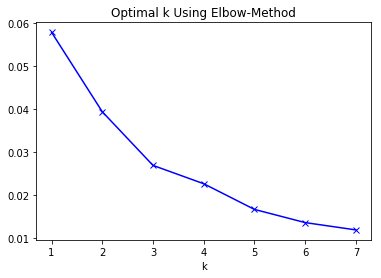

In [26]:
# use elbow method to find the optimal amount of clusters
from scipy.spatial.distance import cdist

distortion = []
K = range(1,8)
for k in K:
    km = KMeans(n_clusters=k).fit(X2)
    distortion.append(sum(np.min(cdist(X2, km.cluster_centers_, 'euclidean'), axis=1))/X2.shape[0])
    
plt.plot(K, distortion, 'bx-')
plt.xlabel('k')
plt.title('Optimal k Using Elbow-Method')
plt.show()

The optimal value of k is 3. After that, the distortion score decreases slowly. Let's try fitting the KMeans model onto our dataset with the optimal k value and find the important features:

In [30]:
cluster_pred = KMeans(n_clusters=3, random_state=1).fit_predict(df)
X_pred = df.copy()
X_pred['cluster_assigned'] = cluster_pred

cluster_df = {}
for nclusters in range(3):
    cluster_df[nclusters] = X_pred.loc[X_pred['cluster_assigned'] == nclusters]
    
for name, frame in cluster_df.items():
    print('Feature: {}'.format(name))
    print('\n')
    print(frame.describe())

Feature: 0


                10k           25k        gender           age      official  \
count  10533.000000  10533.000000  10533.000000  10533.000000  10533.000000   
mean      43.237307    109.150011      0.745846     38.881705    191.978052   
std        3.849276      9.408680      0.435405      9.407618     16.640570   
min       16.620000     45.800000      0.000000     18.000000     80.600000   
25%       41.170000    103.870000      0.000000     31.000000    181.370000   
50%       43.380000    109.930000      1.000000     39.000000    194.750000   
75%       46.000000    116.200000      1.000000     46.000000    205.250000   
max       53.970000    130.170000      1.000000     73.000000    213.930000   

                35k       overall          pace           30k            5k  \
count  10533.000000  10533.000000  10533.000000  10533.000000  10533.000000   
mean     156.590066   5225.923668      7.330385    132.367735     21.637171   
std       13.412314   3050.986149     

* The first cluster comprises of mainly male (~74.6%), with an age range between 29-49, the average pace of 7.3, and the average overall placement at 5226.
* The second cluster has roughly equal numbers of male and female, with an age range between 31-57, the average pace of 11.5, and the average overall placement at 26433.
* The third cluster has slightly more male than female, with an age range between 33-55, the average pace of 8.9, and the average overall placement at 15813.

In [42]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(df)
X_label = df.copy()
X_label['label'] = km.labels_

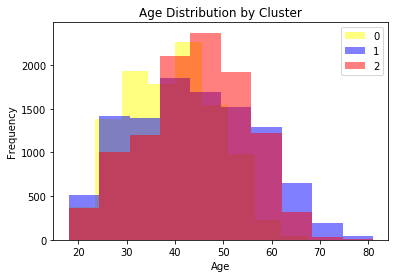

In [43]:
fig,ax = plt.subplots()
colors = {0:'yellow', 1:'blue', 2:'red'}
grouped = X_label.groupby('label')
for key, group in grouped:
    group['age'].plot(ax=ax, kind='hist', label=key, color=colors[key], alpha=0.5)
plt.legend()
plt.xlabel('Age')
plt.title('Age Distribution by Cluster')
plt.show()

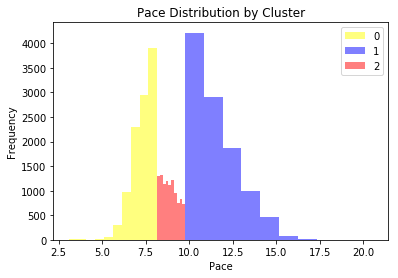

In [44]:
fig,ax = plt.subplots()
for key, group in grouped:
    group['pace'].plot(ax=ax, kind='hist', label=key, color=colors[key], alpha=0.5)
plt.legend()
plt.xlabel('Pace')
plt.title('Pace Distribution by Cluster')
plt.show()

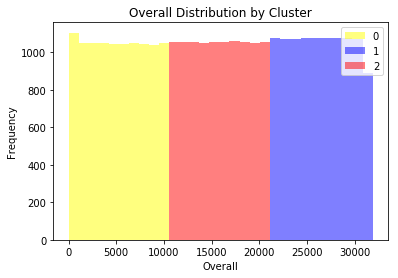

In [50]:
fig,ax = plt.subplots()
for key, group in grouped:
    group['overall'].plot(ax=ax, kind='hist', label=key, color=colors[key], alpha=0.5)
plt.legend()
plt.xlabel('Overall')
plt.title('Overall Distribution by Cluster')
plt.show()

* Cluster 0 is the fastest with a few outliers that can run at 3 or 4 minute pace. 
* Cluster 1 is the slowest. Coincidentally, cluster 1 also has more females and more older participants.
* **It seems like KMeans clusters are grouped based solely on the `overall` placements**